### Downloading Zipped Dataset

In [1]:
!wget https://www.dropbox.com/s/df00b7jnoiok5gc/Brain-Tumor-Dataset.zip?dl=0

--2023-01-27 05:01:11--  https://www.dropbox.com/s/df00b7jnoiok5gc/Brain-Tumor-Dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/df00b7jnoiok5gc/Brain-Tumor-Dataset.zip [following]
--2023-01-27 05:01:12--  https://www.dropbox.com/s/raw/df00b7jnoiok5gc/Brain-Tumor-Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ff6124ed9addf4bc9df3ba5ce.dl.dropboxusercontent.com/cd/0/inline/B1W54B83PALXeM0HQG952c5rQGpv450KPZyohDsYvFN1z0ePWNSw6ytnGfPLo5rGNxJspqLQp-asRF1F5OVqXJebRIR1kXF37a2rCo-WBMx8Dg_9KXkZJgKJuC4pv3C241Zty18ph3fJsr9sgKYTrx1j-xS1fxjvNSsvOvhJGKsQ3w/file# [following]
--2023-01-27 05:01:12--  https://uc3ff6124ed9addf4bc9df3ba5ce.dl.dropboxusercontent.com/cd/0/inline/B1W54B83PALXeM0HQG952c5rQGpv450KPZyohDs

### Creating Directory to Move Unzipped Data to this Directory

In [2]:
!mkdir Brain-Tumor-Dataset

### Unzipping Dataset

In [3]:
!unzip Brain-Tumor-Dataset.zip?dl=0 -d Brain-Tumor-Dataset/

Archive:  Brain-Tumor-Dataset.zip?dl=0
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1).png  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1).tif  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (10).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (10).tif  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (100).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1004).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1005).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1006).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1007).jpg  
  inflating: Brain-Tumor-Dataset/Brain Tumor/Cancer (1008).jpg  


# Residual Networks (ResNet)

__ResNet__ or __Residual Neural Network__ was proposed by ([He et al.](https://arxiv.org/pdf/1512.03385.pdf)) researchers at Microsoft Research namely, _Kaiming He_, _Xiangyu Zhang_, _Shaoqing Ren_ and, _Jian Sun_; which allow us to train much deeper networks than were previously practically feasible. Also, ResNet won [ImageNet](https://www.image-net.org/about.php) Challenge in 2015.

<center>
    <img src="https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/MicrosoftResearch.png?raw=1" alt="Microsoft Research" width="500px"> <br>
</center>

## Problem with Very Deep Neural Networks
The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values).

During training, we might therefore see the magnitude (or norm) of the gradient for the earlier layers descrease to zero very rapidly as training proceeds:
![Vanishing Gradient](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/VanishingGradient.png?raw=1)
<center>
    <b><i>Figure 1:</i></b> <i>The speed of learning decreases very rapidly for the early layers as the network trains</i>
</center>

We are now going to solve this problem by building a Residual Network!

## Building a Residual Network
In ResNet architecture, a *“shortcut”* or a *“skip connection”* allows the gradient to be directly backpropagated to earlier layers:
![Skip Connection](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/SkipConnection.png?raw=1)
<center>
    <b><i>Figure 2:</i></b> <i>A ResNet block showing a skip-connection</i>
</center>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. (There is also some evidence that the ease of learning an identity function--even more than skip connections helping with vanishing gradients--accounts for ResNets' remarkable performance.)

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. We are going to implement both of them.

# ResNet-50 Implementation

## Importing Dependencies

In [7]:
# Import OpenCV which is a Computer Vision library and here we use it to deal with our image dataset
import cv2

# Import NumPy as our model trains on arrays which will be handled by NumPy
import numpy as np

import scipy

# Import OS to interact with operating system
import os

# Import Math to use some mathematical computations
import math

# Import Shutil to move, copy and delete directories and sub-directories
import shutil

# Import glob module which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import glob

# Import mayplotlib and seaborn to visualize the metrics of our model
import matplotlib.pyplot as plt
import seaborn as sns

# Import Keras
import keras

# Import image from keras.preprocessing which is used the deal with dataset images while preprocessing them
from keras.preprocessing import image

# Import Keras ImageDataGenerator which is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.
from keras.preprocessing.image import ImageDataGenerator

# Import scikit-learn metrics whivh will be used to display the metrics of the model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score, roc_auc_score

# Import Keras layers
# Sequential class is used to build a model instance which will be constructed layer-by-layer (i.e., one layer is stacked over previous layer)
# Model class is used to initialize the instance of our CNN architecture (here ResNet50)
# load_model is uded to load the model from pre-existinf weights or models
from keras.models import Sequential, Model, load_model

# Import optimizers.Optimizer is an algorithm which is used for the learning of the model
# SGD (Stochastic Gradient Descent) is an optimization algorithm often used in machine learning applications to find the model parameters that correspond to the best fit between predicted and actual outputs.
from keras.optimizers import SGD

# Import EarlyStopping and ModelCheckpoint
# EarlyStopping is used to halt the learning of the used when the models accuracy does not improve by any significant amount
# ModelCheckpoint is used to save the model or weights in a checkpoint file at some time interval
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Import some Keras layers features which will be used to provide input to the layer, add layer to the model, perform pooling padding and convlution, flattening the image, and batch normalization
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D

# Import glorot_uniform
# GlorotUniform draws samples from a uniform distribution within [-limit, limit] , where limit = sqrt(6 / (fan_in + fan_out)) ( fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
from keras.initializers import glorot_uniform

# Import binary_crossentropy
# Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value.
from keras.losses import binary_crossentropy

## Splitting Dataset into Training, Validation and Testing

In [8]:
DATASET_PATH = "Brain-Tumor-Dataset"

In [9]:
number_of_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(DATASET_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    number_of_images[dir] = len(os.listdir(os.path.join(DATASET_PATH, dir)))

Randomly display any image from each class of the dataset

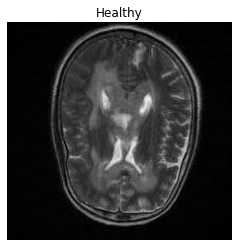

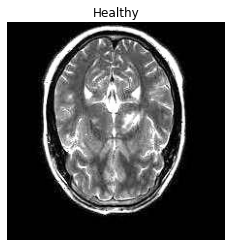

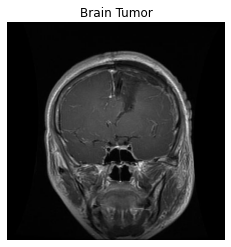

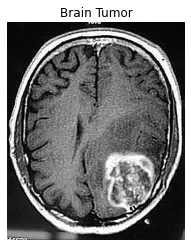

In [10]:
# listing all the subdirectories in our main dataset directory
for dir in os.listdir(DATASET_PATH):
    # picking a random image from each class of the datset
    for img in np.random.choice(os.listdir(os.path.join(DATASET_PATH, dir)), size = 2):
        # read each image with the help of OpenCV
        image = cv2.imread(os.path.join(DATASET_PATH, dir, img))
        # plot the image using matplotlib
        plt.imshow(image); plt.axis("off")
        # give image a title using matplotlib
        plt.title(dir)
        # show or display the image using matplotlib
        plt.show()

___Listing the number of images in each class of our dataset___

In [11]:
print("The dataset contains the following:")
for i, each_class in enumerate(number_of_images):
    print(f"{i + 1}) {number_of_images[each_class]} images of {each_class}")

The dataset contains the following:
1) 2087 images of Healthy
2) 2513 images of Brain Tumor


### Declaring and Defining our Custom Function for Splitting the Dataset

In [12]:
def data_folder(folder_name, split_ratio):
    """
    This function will split the dataset in a given number of new folders namely, Training, Testing and Validation in a given ratio.
    Such that Training:Testing:Validation = x:y:z
    Where,
        x is the number of images in Training Folder
        y is the number of images in Testing Folder
        z is the number of images in Validation Folder
    
    Arguments:
        folder_name: Name of the folder created for splitting the dataset
        split_ratio: Percentage of images of original dataset for every splitted folder_name
    """
    
    # checking if the folder does not already exist
    if not os.path.exists("./" + folder_name):
        # if the folder doesn't already exist then create that folder
        print(f"Creating {folder_name}")
        os.mkdir("./" + folder_name)
    
    # listing all the subdirectories in our main dataset directory
    for dir in os.listdir(DATASET_PATH):
        # checking if that subdirectory for this folder does not already exist
        if not os.path.exists("./" + folder_name + "/" + dir):
            # if it does not already exist then create that subdirectory for this folder
            print(f"Creating {dir} directory for {folder_name} folder")
            os.makedirs("./" + folder_name + "/" + dir)

        # picking random images from each class of the datset and copying it to the Training, Testing or Validation folder
        # size for each directory is the product of number of images in each class and the ratio of train, test, validate folders
        # For example: if Buffalo contains 1000 images and ratio train:test:validate = 70:15:15, then Testing folder will contain 700 images, Testing folder 150 images and Validation Folder 150 images 
        for img in np.random.choice(a = os.listdir(os.path.join(DATASET_PATH, dir)), size = (math.floor(split_ratio * number_of_images[dir])), replace = False):
            
            # pathname of original dataset
            O = os.path.join(DATASET_PATH, dir, img)
            
            # pathname of splitted dataset
            D = os.path.join("./" + folder_name, dir)
            
            # copy each image from original dataset path to splitted dataset path
            shutil.copy(O, D)
    
    else:
        print(f"{folder_name} folder exist")

___Creating Training Folder___

In [13]:
data_folder("Training", 0.7)

Creating Training
Creating Healthy directory for Training folder
Creating Brain Tumor directory for Training folder
Training folder exist


___Creating Validation Folder___

In [14]:
data_folder("Validation", 0.15)

Creating Validation
Creating Healthy directory for Validation folder
Creating Brain Tumor directory for Validation folder
Validation folder exist


___Creating Testing Folder___

In [15]:
data_folder("Testing", 0.15)

Creating Testing
Creating Healthy directory for Testing folder
Creating Brain Tumor directory for Testing folder
Testing folder exist


In [16]:
TRAIN_PATH = "./Training"

In [17]:
TEST_PATH = "./Testing"

In [18]:
VALIDATE_PATH = "./Validation"

___Listing the number of images in each class of our Training Folder___

In [19]:
train_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(TRAIN_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    train_images[dir] = len(os.listdir(os.path.join(TRAIN_PATH, dir)))

print("The Training folder contains the following:")
for i, each_class in enumerate(train_images):
    print(f"{i + 1}) {train_images[each_class]} images of {each_class}")

The Training folder contains the following:
1) 1460 images of Healthy
2) 1759 images of Brain Tumor


___Listing the number of images in each class of our Validation Folder___

In [20]:
validate_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(VALIDATE_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    validate_images[dir] = len(os.listdir(os.path.join(VALIDATE_PATH, dir)))

print("The Validation folder contains the following:")
for i, each_class in enumerate(validate_images):
    print(f"{i + 1}) {validate_images[each_class]} images of {each_class}")

The Validation folder contains the following:
1) 313 images of Healthy
2) 376 images of Brain Tumor


___Listing the number of images in each class of our Testing Folder___

In [21]:
test_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(TEST_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    test_images[dir] = len(os.listdir(os.path.join(TEST_PATH, dir)))

print("The Testing folder contains the following:")
for i, each_class in enumerate(test_images):
    print(f"{i + 1}) {test_images[each_class]} images of {each_class}")

The Testing folder contains the following:
1) 313 images of Healthy
2) 376 images of Brain Tumor


## Preprocessing Images

**ImageDataGenerator()** is used to perfrom augmentation on a given image. Augmentation means that the images are duplicated with some kind of variations that increase the size of the teraining set without aquiring new images.
Augmentation (or variations) that we performed here are the following:
- *zoom_range:* zoom in or zoom out images in a given range
- *width_shift_range:* shift the images horizontally in a given range
- *height_shift_range:* shift the images vertically in a given range
- *shear_range:* compress an vertically or horizontally in a given range, the oringinal image is somewhat distorted.

In [22]:
train_data_generator = ImageDataGenerator(
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15
)

validate_data_generator = ImageDataGenerator()

test_data_generator = ImageDataGenerator()

***flow_from_directory()*** takes the path to a directory & generates batches of augmented data. <br>
**Arguments:**
- *directory:* string, or path to the directory.
- *target_size:* Tuple of integers (height, width), defaults to (256,256). The dimensions to which all images found will be resized.
- *batch_size:* Size of the batches of data (default: 32).
- *shuffle:*  Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.
- *class_mode:* One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned:
    - "categorical" will be 2D one-hot encoded labels,
    - "binary" will be 1D binary labels, "sparse" will be 1D integer labels

In [23]:
train_generator = train_data_generator.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    class_mode = 'binary'
)

Found 3219 images belonging to 2 classes.


In [24]:
train_generator.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [25]:
validate_generator = validate_data_generator.flow_from_directory(
    directory = VALIDATE_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode='binary'
)

Found 689 images belonging to 2 classes.


In [26]:
test_generator = test_data_generator.flow_from_directory(
    directory = TEST_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode='binary'
)

Found 689 images belonging to 2 classes.


In [27]:
test_generator.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [29]:
labels = ['Brain Tumor', 'Healthy']

print(labels)

['Brain Tumor', 'Healthy']


## Defining the Structure of ResNet50

### Identity Block
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:
![Identity Block](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/IdentityBlock.png?raw=1)
<center>
    <b><i>Figure 3:</i></b> <b>Identity Block.</b> <i>Skip connection "skips over" 2 layers.</i>
</center>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras!

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:
![Identity Block](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/IdentityBlock2.png?raw=1)
<center>
    <b><i>Figure 4:</i></b> <b>Identity Block.</b> <i>Skip connection "skips over" 3 layers.</i>
</center>

Here're the individual steps.

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1, 1) and a stride of (1, 1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization.
- The first BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f, f)$ and a stride of (1, 1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization.
- The second BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1, 1) and a stride of (1, 1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization.
- The third BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component.

Final step:
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

In [30]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        stage: integer, used to name the layers, depending on their position in the network
        block: string/character, used to name the layers, depending on their position in the network
    
    Returns:
        X: output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X
   
    """First component of main path"""
    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    """Second component of main path"""
    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    """Third component of main path"""
    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
    # SKIP Connection
    X = Add()([X, X_shortcut])
    # ReLU
    X = Activation('relu')(X)

    return X

### Convolution Block
We've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. We can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:
![Convolution Block](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/ConvolutionBlock.png?raw=1)
<center>
    <b><i>Figure 5:</i></b> <i>Convolution Block.</i>
</center>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. <br>
The details of the convolutional block are as follows:

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1, 1) and a stride of $(s, s)$. Its padding is "valid" and its name should be `conv_name_base + '2a'`.
- The first BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

Second component of main path:
- The second CONV2D has $F_2$ filters of $(f, f)$ and a stride of (1, 1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of (1, 1) and a stride of (1, 1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component.

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1, 1) and a stride of $(s, s)$. Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The BatchNorm is normalizing the channels axis. Its name should be `bn_name_base + '1'`.

Final step:
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters.

In [31]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        stage: integer, used to name the layers, depending on their position in the network
        block: string/character, used to name the layers, depending on their position in the network
        s: Integer, specifying the stride to be used
    
    Returns:
        X: output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    """First component of main path"""
    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    """Second component of main path"""
    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    """Third component of main path"""
    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    """Shortcut Path"""
    # Shortcut CONV2D
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    # Shortcut Batch Norm
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
    # Shortcut or Skip Connection
    X = Add()([X, X_shortcut])
    # ReLU
    X = Activation('relu')(X)

    return X

## Building ResNet Model (50 Layers)
The ResNet-50 model consists of 5 stages each with a convolution and Identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. The ResNet-50 has over 23 million trainable parameters. <br>
The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means we should stack 3 identity blocks together.
![ResNet-50 Architecture](https://github.com/hamzaziizzz/ResNet-Implementation/blob/main/img/ResNet50.png?raw=1)
<center>
    <b><i>Figure 6:</i></b> <i>ResNet-50 Model</i>
</center>

The details of this ResNet-50 model are: <br>
- Zero-padding pads the input with a pad of (3, 3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7, 7) and uses a stride of (2, 2). Its name is *"conv1"*.
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3, 3) window and a (2, 2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64, 64, 256], *"f"* is 3, *"s"* is 1 and the block is *"a"*.
    - The 2 identity blocks use three set of filters of size [64, 64, 256], *"f"* is 3 and the blocks are *"b"* and *"c"*.
- Stage 3:
    - The convolutional block uses three set of filters of size [128, 128, 512], *"f"* is 3, *"s"* is 2 and the block is *"a"*.
    - The 3 identity blocks use three set of filters of size [128, 128, 512], *"f"* is 3 and the blocks are *"b"*, *"c"* and *"d"*.
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], *"f"* is 3, *"s"* is 2 and the block is *"a"*.
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], *"f"* is 3 and the blocks are *"b"*, *"c"*, *"d"*, *"e"* and *"f"*.
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], *"f"* is 3, *"s"* is 2 and the block is *"a"*.
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], *"f"* is 3 and the blocks are *"b"* and *"c"*.
- The 2D Average Pooling uses a window of shape (2, 2) and its name is *"avg_pool"*.
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

In [32]:
def ResNet50(input_shape=(224, 224, 3)):
    """
    Implementation of the popular ResNet50 the following architecture:
        CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
        input_shape: shape of the images of the dataset
        classes: integer, number of classes

    Returns:
        model: a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # ZERO PAD
    X = ZeroPadding2D((3, 3))(X_input)

    
    """Stage 1"""
    # CONV
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # ReLU
    X = Activation('relu')(X)
    # MAX POOL
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    
    """Stage 2"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # ID BLOCK x2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    
    """Stage 3"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    # ID BLOCK x3
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    
    """Stage 4"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    # ID BLOCK x5
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    
    """Stage 5"""
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    # ID BLOCK x2
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    # Create Model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    # return ResNet50 as model
    return model

***Defining Base Model***

In [33]:
base_model = ResNet50(input_shape = (224, 224, 3))

2023-01-27 05:34:11.348431: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 05:34:11.738620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17969 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:bd:00.0, compute capability: 8.0


***Creating Output Layer***

In [34]:
head_model = base_model.output

# Flatten the output of our model
head_model = Flatten()(head_model)

# Constructing fully connected layer
head_model = Dense(256, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense(128, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense(1, activation='sigmoid', name='fc3', kernel_initializer=glorot_uniform(seed=0))(head_model)

In [35]:
model = Model(
    inputs = base_model.input, 
    outputs = head_model
)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### `compile` method
Configures the model for training.
#### *Arguments*
- **optimizer:** String (name of optimizer) or optimizer instance.
- **loss:** Loss function. May be a string (name of loss function), or a `keras.losses` instance.
- **metrics:** List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a keras.metrics instance.

In [37]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

## Defining and Initializing Callbacks for our Model

### Early Stopping
Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to maximize the validation accuracy. With this, the metric to be monitored would be 'val_accuracy', and mode would be 'max'.

#### *Arguments*
- **monitor:** Quantity to be monitored.
- **min_delta:** Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- **mode:** One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
- **verbose:** Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
- **patience:** Number of epochs with no improvement after which training will be stopped.

In [38]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.01,
    mode = 'max',
    verbose = 1,
    patience = 20
)

### Model Checkpoint
ModelCheckpoint() callback is used in conjunction with training using model.fit() or model.fit_generator to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

A few options this callback provides include:
- Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.
- Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.
- The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.
- Whether only weights are saved, or the whole model is saved.

#### *Arguments*
- **filepath:** string or, path to save the model file.
- **monitor:** The metric name to monitor.
    - Prefix the name with "val_" to monitor validation metrics.
    - Use "loss" or "val_loss" to monitor the model's total loss.
    - If you specify metrics as strings, like "accuracy", pass the same string (with or without the "val_" prefix).
- **save_best_only:** if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
- **mode:** one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_accuracy, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'accuracy' and are set to min for the rest of the quantities.

In [39]:
model_checkpoint = ModelCheckpoint(
    filepath = './model/best_model.h5',
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

### model.fit_generator()
*(Deprecated) Fits the model on data yielded batch-by-batch by a generator.* <br>
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU. If we have a large dataset that cannot be loaded in the RAM at once, fit_generator() is the recommended way of working.

#### *Arguments*
- **generator:** A generator (e.g. like the one provided by `flow_from_directory()`).
    The output of the generator must be a list of one of these forms:
    ```
    - (inputs, targets)
    - (inputs, targets, sample_weights)
    ```
    This list (a single output of the generator) makes a single batch.
- **validation_data:** this can be either:
    - a generator for the validation data
    - a list (inputs, targets)
    - a list (inputs, targets, sample_weights). on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.
- **steps_per_epoch:** Total number of steps (batches of samples) to yield from `generator` before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of samples if your dataset divided by the batch size.
- **epochs:** Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by `steps_per_epoch`.
- **verbose:** Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch).
- **callbacks:** List of callbacks to apply during training.

In [40]:
model_history = model.fit_generator(
    generator = train_generator,
    validation_data = validate_generator,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]
)

/tmp/ipykernel_389/4169381044.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/100


2023-01-27 05:34:57.320008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-01-27 05:34:58.229636: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 [==============================] - 34s 280ms/step - loss: 2.0505 - accuracy: 0.5135 - val_loss: 0.7418 - val_accuracy: 0.4543
Epoch 2/100
101/101 [==============================] - 28s 272ms/step - loss: 0.8705 - accuracy: 0.5054 - val_loss: 3.2730 - val_accuracy: 0.5457
Epoch 3/100
101/101 [==============================] - 27s 271ms/step - loss: 0.6421 - accuracy: 0.6508 - val_loss: 0.5901 - val_accuracy: 0.7257
Epoch 4/100
101/101 [==============================] - 27s 263ms/step - loss: 0.5606 - accuracy: 0.7251 - val_loss: 0.5529 - val_accuracy: 0.6952
Epoch 5/100
101/101 [==============================] - 28s 273ms/step - loss: 0.5213 - accuracy: 0.7561 - val_loss: 0.5138 - val_accuracy: 0.7460
Epoch 6/100
101/101 [==============================] - 27s 262ms/step - loss: 0.4846 - accuracy: 0.7651 - val_loss: 0.6730 - val_accuracy: 0.7184
Epoch 7/100
101/101 [==============================] - 27s 261ms/step - loss: 0.4360 - accuracy: 0.7975 - val_loss: 0.5500 - val_accurac

#### Plotting Accuracy vs Validation Accuracy

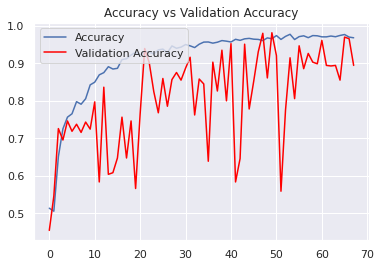

In [41]:
sns.set()

plt.plot(model_history.history['accuracy'], label="Accuracy")
plt.plot(model_history.history['val_accuracy'], c='red', label="Validation Accuracy")

plt.title("Accuracy vs Validation Accuracy")
plt.legend(loc="upper left")
plt.show()

#### Plotting Loss vs Validation Loss

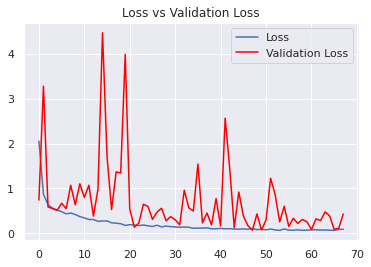

In [42]:
sns.set()

plt.plot(model_history.history['loss'], label="Loss")
plt.plot(model_history.history['val_loss'], c='red', label="Validation Loss")

plt.title("Loss vs Validation Loss")
plt.legend(loc="upper right")
plt.show()

### model.load_weights()
Loads all layer weights from a saved files.
#### *Arguments*
- **filepath:** String, path to the weights file to load.

In [43]:
model.load_weights("./model/best_model.h5")

### model.evaluate_generator()
*(Deprecated)* Evaluates the model on a data generator.

In [44]:
evaluation = model.evaluate_generator(test_generator)

print(f"The accuracy of our model on Testing Data is {(evaluation[1] * 100):.3f}%")

/tmp/ipykernel_389/465588726.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = model.evaluate_generator(test_generator)


The accuracy of our model on Testing Data is 96.952%


### model.predict_generator()
*(Deprecated)* Generates predictions for the input samples from a data generator.
#### *Arguments*
- **generator:** Generator yielding batches of input samples.
- **steps:** Total number of steps (batches of samples) to yield from `generator` before stopping.
- **verbose:** verbosity mode, 0 or 1.
- **workers:** Maximum number of threads to use for parallel processing.

In [45]:
predictions = model.predict_generator(
    generator = test_generator,
    steps = np.ceil(test_generator.samples / test_generator.batch_size),
    verbose = 0,
    workers = 0
)

/tmp/ipykernel_389/2229688988.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(


In [46]:
print(predictions)

[[1.40215786e-08]
 [2.94442981e-09]
 [5.06988158e-07]
 [2.23355015e-12]
 [3.97347932e-08]
 [5.59887523e-03]
 [1.05443585e-03]
 [1.94255874e-01]
 [3.50689024e-01]
 [1.55634794e-09]
 [1.79911233e-08]
 [3.82425398e-01]
 [3.75817537e-01]
 [3.41200661e-07]
 [8.05093579e-12]
 [3.13870623e-05]
 [3.64291569e-10]
 [4.81291136e-06]
 [1.59074730e-07]
 [2.32257554e-03]
 [2.41316512e-01]
 [3.18311848e-08]
 [2.37375312e-02]
 [1.03336670e-05]
 [3.33891023e-07]
 [1.34303045e-04]
 [8.23210826e-07]
 [1.79281652e-01]
 [9.34979738e-09]
 [3.47640679e-07]
 [8.36986292e-04]
 [2.61449797e-13]
 [1.98957240e-11]
 [1.69256091e-05]
 [2.86554638e-07]
 [1.39377695e-02]
 [7.94195909e-09]
 [9.77781355e-01]
 [3.64954555e-09]
 [8.55802398e-08]
 [5.07874074e-06]
 [3.89173671e-09]
 [2.53750030e-02]
 [1.00392755e-02]
 [2.15207189e-02]
 [4.01953359e-09]
 [1.51890155e-04]
 [1.11142129e-09]
 [4.66858401e-05]
 [6.11513108e-03]
 [1.08670335e-08]
 [1.32667767e-02]
 [1.68702658e-02]
 [2.81989069e-05]
 [4.38100800e-09]
 [2.851669

In [47]:
# number of images in our testing dataset
test_generator.samples

689

In [48]:
# batch size for testing data generator
test_generator.batch_size

32

In [49]:
# store the predicted outcomes of our model

# if the prediction probability is greater than 0.5, then it belongs to class 0 (i.e., Zebra) otherwise class 1 (i.e., Buffalo)
predicted_classes = np.where(predictions > 0.5, 1, 0)

print(predicted_classes)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


In [50]:
# classes found in our testing data generator
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

## Metrics for our ResNet-50 Convolutional Neural Network

### Confustion Matrix

In [51]:
c_m = confusion_matrix(test_generator.classes, predicted_classes)

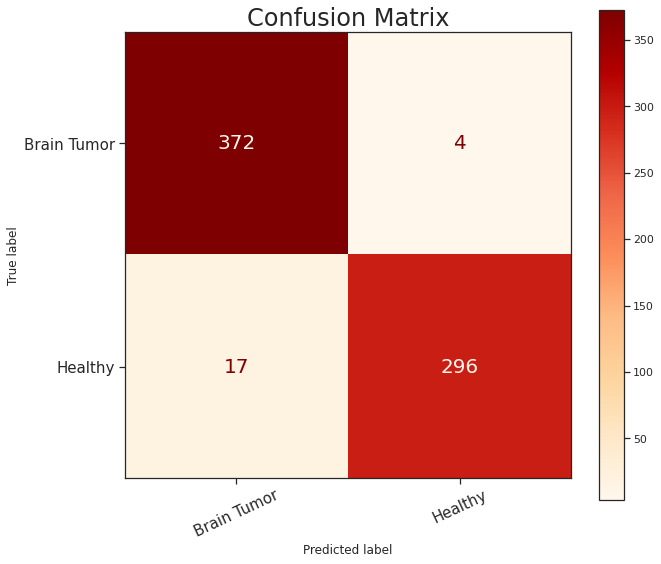

In [52]:
sns.set_style("ticks")

# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)

# Showing the plot
plt.show()

### Classification Report

In [53]:
print("Classification Report containes the following metrics:\n")
print(classification_report(test_generator.classes, predicted_classes, target_names = labels))

Classification Report containes the following metrics:

              precision    recall  f1-score   support

 Brain Tumor       0.96      0.99      0.97       376
     Healthy       0.99      0.95      0.97       313

    accuracy                           0.97       689
   macro avg       0.97      0.97      0.97       689
weighted avg       0.97      0.97      0.97       689



### Precission-Recall Curve

In [54]:
precision, recall, threshold = precision_recall_curve(test_generator.classes, predictions)

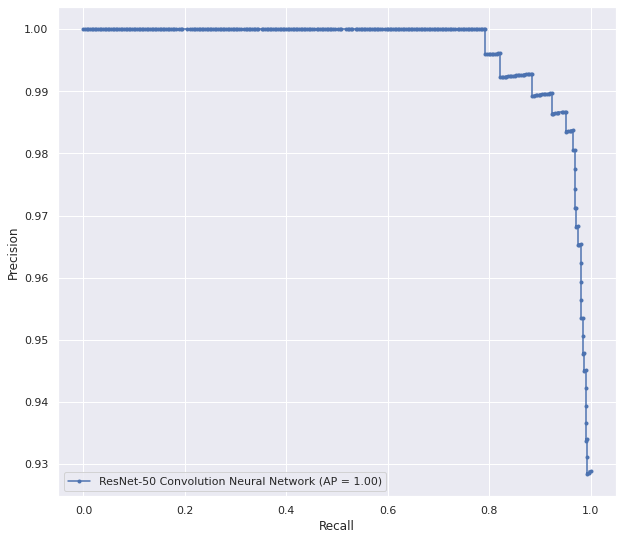

In [55]:
sns.set()

PrecisionRecallDisplay(
    precision = precision,
    recall = recall,
    average_precision = average_precision_score(test_generator.classes, predictions),
    estimator_name = "ResNet-50 Convolution Neural Network"
).plot(marker = ".")

plt.show()

### ROC-AUC Curve

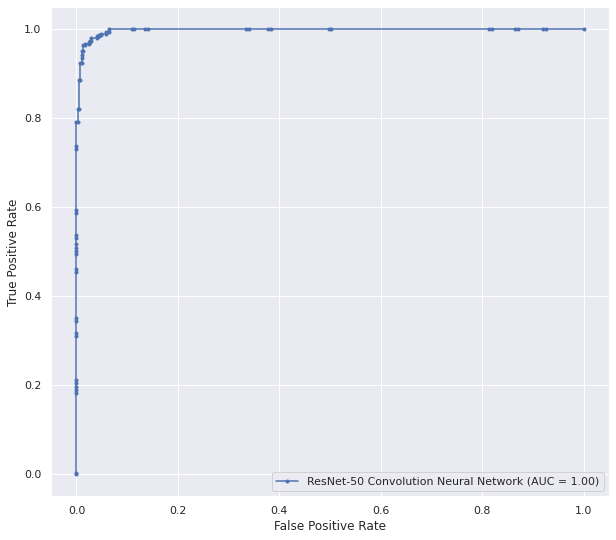

In [56]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay

false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, predictions)

RocCurveDisplay(
    fpr = false_positive_rate,
    tpr = true_positive_rate,
    roc_auc = auc(false_positive_rate, true_positive_rate),
    estimator_name = "ResNet-50 Convolution Neural Network"
).plot(marker = ".")

plt.show()

## Perform Prediction on Some Random Images

### model.predict()
Generates output predictions for the input samples.
#### *Arguments*
- **x:** Input samples. It could be:
    - A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
    - A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
    - A generator

### numpy.expand_dims() 
Expand the shape of an array. <br>
Insert a new axis that will appear at the axis position in the expanded array shape.
#### *Arguments*
- **a:** *array_like* <br> Input array.
- **axis:** *int or tuple of ints* <br> Position in the expanded axes where the new axis (or axes) is placed.

In [59]:
def predict_image(image_path):
    """
    This function will take image path as an argument and predict whether it is a buffalo or zebra.
    
    Arguments:
        image_path: string, or path of the image where it is located.
    """
    
    # read the image from image_path with the help of OpenCV
    image = cv2.imread(image_path)
    # resize the image to (224, 224) as our model accepts the input of size (224, 224)
    resized_image = cv2.resize(image, (224, 224))
    
    prediction = model.predict(np.expand_dims(a = resized_image, axis = 0), verbose = 0)
    
    if prediction < 0.5:
        print("Predicted Label: Healthy")
    else:
        print("Predicted Label: Brain Tumor")
    
    plt.imshow(image); plt.axis("off")
    plt.show()

Predicted Label: Brain Tumor


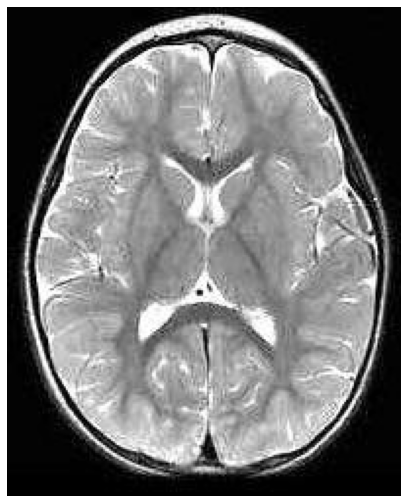




Predicted Label: Healthy


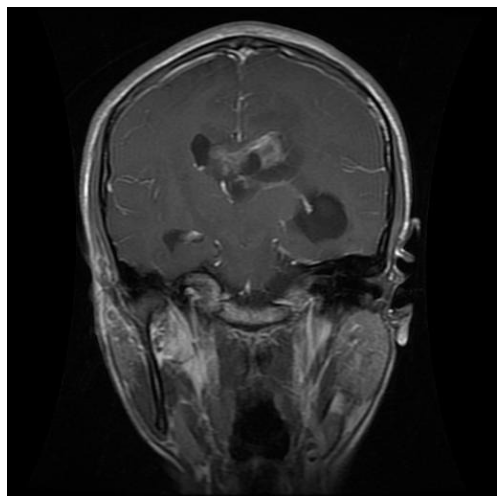

In [60]:
# list all the directories in our main dataset path
for directory in os.listdir(DATASET_PATH):
    # pick a single random image from each sub-directory of main dataset path
    for img in np.random.choice(os.listdir(os.path.join(DATASET_PATH, directory)), size = 1):
        # perform prediction on each image that is being chosen
        predict_image(os.path.join(DATASET_PATH, directory, img))
        print("\n\n")